# Text Analysis Part2 - Named Entity Recognition (NER) 



In [3]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tag import CRFTagger
import re, unicodedata
import nltk
from nltk.stem import PorterStemmer
from nltk import pos_tag
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

# 1. Load the dataset
Load the BC5CDR dataset from the Hugging Face datasets library.
Use train and validation sets for training, and the test set for testing.

Map the labels to the following tags:
```
{
    0: "O",
    1: "B-Chemical",
    2: "B-Disease",
    3: "I-Disease",
    4: "I-Chemical"
}

In [4]:
dataset = load_dataset(
    "tner/bc5cdr", 
    cache_dir="./NLP_data_cache",
)

train_dataset= dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

In [5]:
# 定义标签的映射
ner_tag_mapping= {0: "O",1: "B-Chemical",2: "B-Disease",3: "I-Disease",4: "I-Chemical"}

train_set=[list(zip(s['tokens'], [ner_tag_mapping[tok] for tok in s['tags']])) for s in train_dataset][:-1]
val_set=[list(zip(s['tokens'], [ner_tag_mapping[tok] for tok in s['tags']])) for s in val_dataset][:-1]
test_set=[list(zip(s['tokens'], [ner_tag_mapping[tok] for tok in s['tags']])) for s in test_dataset][:-1]

train_set=train_set+val_set
test_tokens = [s['tokens'] for s in test_dataset][:-1]
test_tags = [[ner_tag_mapping[tok] for tok in s['tags']] for s in test_dataset][:-1]

# 2. Train a CRF NER tagger



## 2.1 Train a CRF NER tagger and evaluate its performance
To evaluate a CRF NER tagger, we need to calculate the span-level F1 score. The span-level F1 score is calculated on the level of named entities, and it is the harmonic mean of precision and recall. 



In [6]:
# 1. Customized CRF Tagger
class CustomCRFTagger(CRFTagger):
    def _get_features(self, tokens, idx):

        token = tokens[idx]
        feature_list = [
            'bias',  # 偏置项
            'word.lower=' + token.lower(), # 小写形式
            'word[-3:]=' + token[-3:],  # 后缀
            'word[-2:]=' + token[-2:],  # 后缀
            'word.isupper=%s' % token.isupper(), # 是否全大写
            'word.istitle=%s' % token.istitle(), # 是否首字母大写
            'word.isdigit=%s' % token.isdigit(), # 是否是数字
            'word.chemical_suffix=%s' % bool(re.match(r'.*(ate|ium|ide|ite)$', token.lower())),  # 化学品常见后缀
            'word.disease_suffix=%s' % bool(re.match(r'.*(itis|osis|oma|pathy|ectomy|megaly)$', token.lower())),  # 疾病常见后缀
            'word.disease_prefix=%s' % bool(re.match(r'^(Arthro|Cysto|Osteo|Neuro)', token)),  # 疾病常见前缀+后缀
        ]
        
        # 添加上下文特征
        if idx > 0: # 如果不是句子的第一个单词
            prev_token = tokens[idx-1]
            feature_list.extend([
                '-1:word.lower=' + prev_token.lower(), # 前一个单词的小写形式
                '-1:word.istitle=%s' % prev_token.istitle(), # 前一个单词是否首字母大写
                '-1:word.isupper=%s' % prev_token.isupper(), # 前一个单词是否全大写
            ])
        else:
            feature_list.append("BOS")  # 句子开始
        
        if idx < len(tokens)-1: # 如果不是句子的最后一个单词
            next_token = tokens[idx+1]
            feature_list.extend([
                '+1:word.lower=' + next_token.lower(), # 后一个单词的小写形式
                '+1:word.istitle=%s' % next_token.istitle(), # 后一个单词是否首字母大写
                '+1:word.isupper=%s' % next_token.isupper(), # 后一个单词是否全大写
            ])
        else:
            feature_list.append("EOS")  # 句子结束
        
        return feature_list

In [8]:
# 2. POS Tagger
class CustomCRFTaggerWithPOS(CRFTagger):
    def _get_features(self, tokens, idx):
        token, pos = tokens[idx] # 这里的token=word, pos=POS标签
        feature_list = [
            'bias',
            'word.lower=' + token.lower(),
            'word[-3:]=' + token[-3:],
            'word[-2:]=' + token[-2:],
            'word.isupper=%s' % token.isupper(),
            'word.istitle=%s' % token.istitle(),
            'word.isdigit=%s' % token.isdigit(),
            'word.ischemical=%s' % bool(re.match(r'.*(ate|ium|ide|ite)$', token.lower())),
            'word.disease_suffix=%s' % bool(re.match(r'.*(itis|osis|oma|pathy|paresis|plegia|odynia|spasm|algia|megaly|pania|emia)$', token.lower())),
            'word.disease_prefix=%s' % bool(re.match(r'^(arthro|cysto|osteo|neuro)', token, re.IGNORECASE)),
            'pos=' + pos,  # 添加POS特征
        ]

        if idx > 0: # 如果不是句子的第一个单词
            prev_token, prev_pos = tokens[idx-1] # 获取前一个单词的大小写形式和POS标签
            feature_list.extend([
                '-1:word.lower=' + prev_token.lower(),
                '-1:word.istitle=%s' % prev_token.istitle(),
                '-1:word.isupper=%s' % prev_token.isupper(),
                '-1:pos=' + prev_pos,
            ])
        else:
            feature_list.append("BOS")
        
        if idx < len(tokens) - 1: # 如果不是句子的最后一个单词
            next_token, next_pos = tokens[idx+1] # 获取后一个单词的大小写形式和POS标签
            feature_list.extend([
                '+1:word.lower=' + next_token.lower(),
                '+1:word.istitle=%s' % next_token.istitle(),
                '+1:word.isupper=%s' % next_token.isupper(),
                '+1:pos=' + next_pos,
            ])
        else:
            feature_list.append("EOS")
        
        return feature_list

In [9]:
# 3. POS and Stemming Tagger
class CustomCRFTaggerWithPOSAndStemming(CustomCRFTaggerWithPOS):
    def __init__(self, *args, **kwargs):
        super(CustomCRFTaggerWithPOSAndStemming, self).__init__(*args, **kwargs)
        self.stemmer = PorterStemmer()

    def _get_features(self, tokens, idx):
        token, pos = tokens[idx]  # 这里的token=word, pos=POS标签
        stem = self.stemmer.stem(token)  # 提取词干

        feature_list = super(CustomCRFTaggerWithPOSAndStemming, self)._get_features(tokens, idx)

        # 添加词干特征
        feature_list.append('stem=' + stem)

        return feature_list

In [12]:
# extract pos tags as features
def preprocess_data_for_pos(data):
    """将数据集转换为包含词性标注的格式，同时保留NER标签"""
    processed_data = []
    for sent in data:
        words, ner_tags = zip(*sent)  # 分离单词和NER标签
        pos_tags = [pos for word, pos in pos_tag(words)]  # 对单词进行词性标注
        
        processed_sent = [((word, pos), tag) for word, pos, tag in zip(words, pos_tags, ner_tags)]
        processed_data.append(processed_sent)
    return processed_data

train_set_pos = preprocess_data_for_pos(train_set) # [(('word1', 'pos1'), 'tag1'), (('word2', 'pos2'), 'tag2'), ...]
test_set_pos = preprocess_data_for_pos(test_set)

# transform predicted tags to the same format as test_tags
def transform_tags(predicted_tags):
    # 将预测的标签转换为[[tag1, tag2, ...], [tag1, tag2, ...], ...]的形式,与test_tags的形式一致
    return [[tag for word, tag in sent] for sent in predicted_tags]

# Train a CRF NER tagger
def train_CRF_NER_tagger(train_set, tagger_name):
    tagger = tagger_name
    tagger.train(train_set, 'crf.tagger')
    return tagger  # return the trained model

In [13]:
# Original CRF Tagger
tagger = train_CRF_NER_tagger(train_set,CRFTagger())
predicted_tags = tagger.tag_sents(test_tokens) # [('word1', 'tag1'), ('word2', 'tag2'), ...]  BIO标签
# cal_span_level_f1(test_set, predicted_tags)

# 使用seqeval库计算F1值
transformed_predicted_tags = transform_tags(predicted_tags)
print(classification_report(test_tags, transformed_predicted_tags)) # test_tags: [['tag1', 'tag2', ...], ['tag1', 'tag2', ...], ...] BIO标签

              precision    recall  f1-score   support

    Chemical       0.90      0.81      0.85      5384
     Disease       0.80      0.63      0.71      4421

   micro avg       0.86      0.73      0.79      9805
   macro avg       0.85      0.72      0.78      9805
weighted avg       0.86      0.73      0.79      9805


In [14]:
# Customized CRF Tagger
tagger = train_CRF_NER_tagger(train_set,CustomCRFTagger())
predicted_tags = tagger.tag_sents(test_tokens)
# cal_span_level_f1(test_set, predicted_tags)

transformed_predicted_tags = transform_tags(predicted_tags)
print(classification_report(test_tags, transformed_predicted_tags))

              precision    recall  f1-score   support

    Chemical       0.92      0.82      0.87      5384
     Disease       0.84      0.69      0.76      4421

   micro avg       0.88      0.76      0.82      9805
   macro avg       0.88      0.75      0.81      9805
weighted avg       0.88      0.76      0.82      9805


In [16]:
# Customized with POS CRF Tagger
test_tokens_pos = [[(word, pos) for (word, pos), tag in sent] for sent in test_set_pos]

tagger = train_CRF_NER_tagger(train_set_pos, CustomCRFTaggerWithPOS())
predicted_tags = tagger.tag_sents(test_tokens_pos)
# cal_span_level_f1(test_set, predicted_tags)

transformed_predicted_tags = transform_tags(predicted_tags)
print(classification_report(test_tags, transformed_predicted_tags))

In [17]:
# Customized with POS and Stemming CRF Tagger
tagger = train_CRF_NER_tagger(train_set_pos, CustomCRFTaggerWithPOSAndStemming())
predicted_tags = tagger.tag_sents(test_tokens_pos)
# cal_span_level_f1(test_set, predicted_tags)

transformed_predicted_tags = transform_tags(predicted_tags)
print(classification_report(test_tags, transformed_predicted_tags))

              precision    recall  f1-score   support

    Chemical       0.92      0.83      0.87      5384
     Disease       0.84      0.73      0.78      4421

   micro avg       0.89      0.78      0.83      9805
   macro avg       0.88      0.78      0.83      9805
weighted avg       0.89      0.78      0.83      9805


1. 原版Tagger：0.8511，0.7078，0.7794
2. 自定义Tagger：0.8648，0.7601，0.8125
3. 自定义+pos：0.8744，0.7636，0.8140
4. 自定义+pos+stem：0.8730，0.7845，0.8288

In [31]:
def analyze_tagging_errors(test_set, predicted_tags):
    errors = []
    # 比较预测结果和实际标签
    for sent_idx, (sent, pred) in enumerate(zip(test_set, predicted_tags)):
        sentence_errors = []
        for ((word, true_tag), (pred_data, pred_tag)) in zip(sent, pred):
            if true_tag != pred_tag:
                error_type = (true_tag, pred_tag)
                sentence_errors.append((word, error_type))
        if sentence_errors:
            original_sentence = " ".join([word for (word, _) in sent])
            errors.append((sent_idx, original_sentence, sentence_errors))
    return errors

# 使用函数
errors = analyze_tagging_errors(test_set, predicted_tags) # [(sent_idx, original_sentence, [(word, (true_tag, pred_tag)), ...]), ...]

# 打印错误
for error in errors[0:5]:
    sent_idx, original_sentence, sentence_errors = error
    print(f"Sentence {sent_idx + 1}: {original_sentence}")
    for word, (true_tag, pred_tag) in sentence_errors:
        print(f"   Word '{word}': True tag = {true_tag}, Predicted tag = {pred_tag}")

Sentence 3: Famotidine is a histamine H2 - receptor antagonist used in inpatient settings for prevention of stress ulcers and is showing increasing popularity because of its low cost .
   Word 'histamine': True tag = O, Predicted tag = B-Chemical
   Word 'ulcers': True tag = B-Disease, Predicted tag = O
Sentence 9: After a single oral dose of 4 mg / kg indomethacin ( IDM ) to sodium and volume depleted rats plasma renin activity ( PRA ) and systolic blood pressure fell significantly within four hours .
   Word 'IDM': True tag = B-Chemical, Predicted tag = O
   Word 'PRA': True tag = O, Predicted tag = B-Chemical
Sentence 13: Scleroderma renal crisis ( SRC ) is a rare complication of systemic sclerosis ( SSc ) but can be severe enough to require temporary or permanent renal replacement therapy .
   Word 'SRC': True tag = B-Disease, Predicted tag = O
   Word 'SSc': True tag = B-Disease, Predicted tag = O
Sentence 14: Moderate to high dose corticosteroid use is recognized as a major risk 

Sentence 9: After a single oral dose of 4 mg / kg indomethacin ( IDM ) to sodium and volume depleted rats plasma renin activity ( PRA ) and systolic blood pressure fell significantly within four hours .
Word 'IDM': True tag = B-Chemical, Predicted tag = O
Word 'PRA': True tag = O, Predicted tag = B-Chemical


缩写的错误识别和遗漏，如“IDM”和“SRC”未被识别为化学物质和疾病，表明模型在处理特定领域（如医学领域）的缩写时效果不佳。对于具有特定上下文的疾病缩写，如“SRC”和“SSc”，模型表现出连续性的识别问题，这些缩写在多个句子中被一致遗漏。

这些错误反映出模型在理解上下文、处理领域特定缩写以及一致性标记上存在的挑战。针对这些问题，未来的改进措施可以包括使用更先进的上下文依赖的模型如 BERT 或其变种，这些模型能更好地理解词语在句子中的具体含义和用法。另一方面，加强训练数据中上下文多样性，确保模型可以在多种句子结构中正确理解和标记实体。并且可以增强对缩写和同义词的处理能力，以及增加训练数据的多样性和专业审核。通过这些方法，可以提高模型的准确性和鲁棒性，从而在实际应用中减少错误标记。

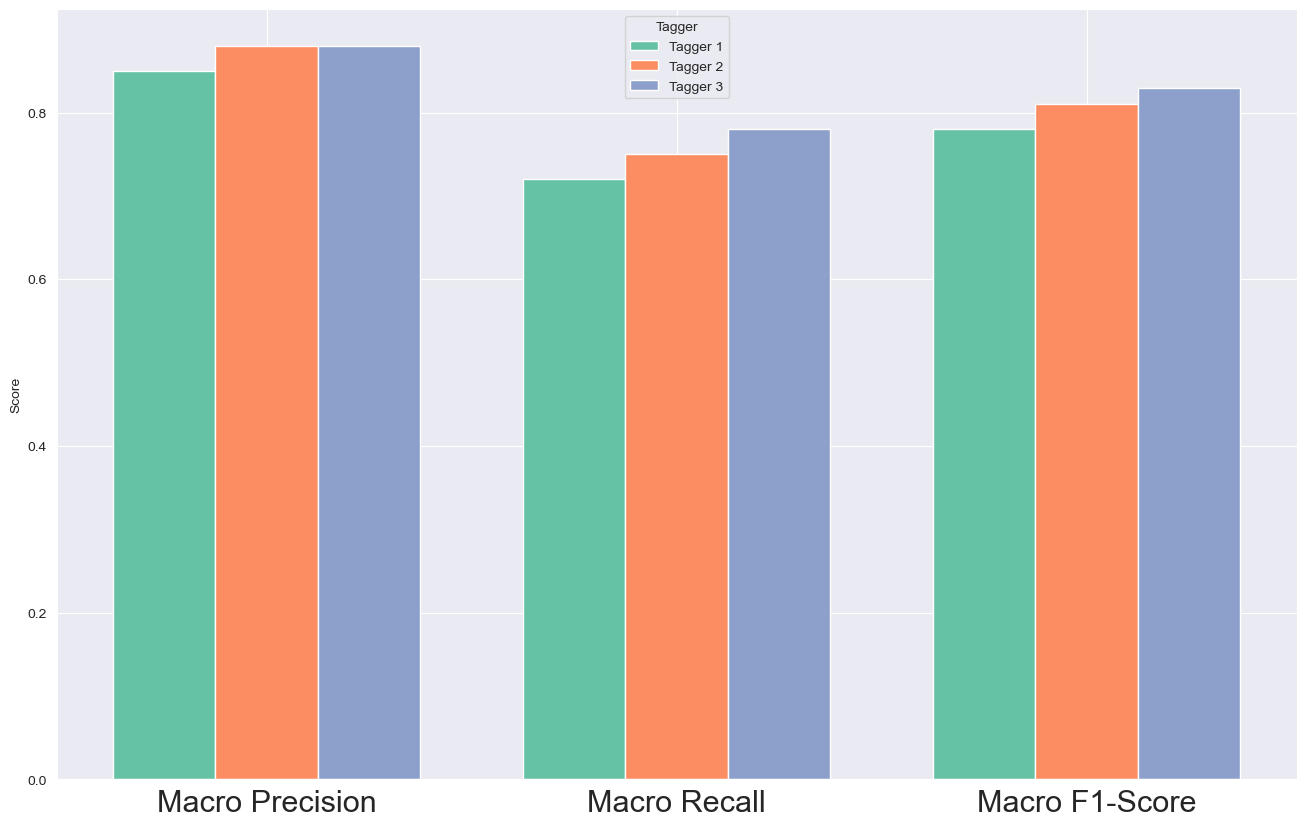

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

# 数据
taggers = ['Tagger 1', 'Tagger 2', 'Tagger 3']
precision_macro = [0.85, 0.88, 0.88]
recall_macro = [0.72, 0.75, 0.78]
f1_macro = [0.78, 0.81, 0.83]
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1-Score']

# 设置Seaborn的颜色调色板
colors = sns.color_palette("Set2")

# 创建柱状图
fig, ax = plt.subplots(figsize=(16, 10))
bar_width = 0.25  # 柱宽

# 绘制柱状图
for i, tagger in enumerate(taggers):
    ax.bar([x + i * bar_width for x in range(len(metrics))], 
           [precision_macro[i], recall_macro[i], f1_macro[i]], 
           bar_width, label=tagger, color=colors[i])

# 设置图表标题和标签
# ax.set_xlabel('Metric')
ax.set_ylabel('Score')
# ax.set_title('Comparison of Macro Average Scores by Tagger')
ax.set_xticks([x + bar_width for x in range(len(metrics))])
ax.set_xticklabels(metrics,fontsize=22)
ax.legend(title="Tagger")

# 显示图表
plt.show()


# 3. Calculate the similarity of Disease Entities

首先需要将测试集中的疾病实体提取出来，并将其转换为带有下划线的形式，以便在建立词向量模型时对整个实体进行识别，而不是单独识别其中的词。然后，我们将使用Word2Vec模型建立词嵌入向量，并分别使用余弦相似度和皮尔森相关系数计算给定疾病实体与其他疾病实体之间的相似性。

In [93]:
def extract_diseases(test_set):
    diseases = []
    current_disease = []  # 用于存储当前正在处理的疾病名称（可能跨越多个词）

    for sentence in test_set:  # 遍历句子
        for word, tag in sentence:  # 遍历句子中的每个单词和标签
            if tag == 'B-Disease':
                if current_disease:  # 如果当前疾病名称不为空，说明已经到了一个新的疾病名称的开始
                    diseases.append(" ".join(current_disease))  # 将当前疾病名称添加到列表中
                    current_disease = []  # 重置当前疾病名称列表
                current_disease.append(word)  # 开始新的疾病名称
            elif tag == 'I-Disease' and current_disease:  # 如果是疾病名称的一部分，并且当前疾病名称列表不为空
                current_disease.append(word)  # 添加到当前疾病名称
            elif current_disease:  # 如果当前有未完成的疾病名称，并且遇到了非疾病标签
                diseases.append(" ".join(current_disease))  # 将当前疾病名称添加到列表中
                current_disease = []  # 重置当前疾病名称列表

    if current_disease:  # 检查并添加最后一个疾病名称（如果有）
        diseases.append(" ".join(current_disease))

    return diseases

# 提取测试集中的疾病名称
test_diseases = extract_diseases(test_set)

# 将疾病实体中的空格替换为下划线
transformed_test_diseases = [disease.replace(" ", "_") for disease in test_diseases]

transformed_test_diseases[:10]

['delirium',
 'ulcers',
 'delirium',
 'delirium',
 'hypotension',
 'scleroderma_renal_crisis',
 'Scleroderma_renal_crisis',
 'SRC',
 'systemic_sclerosis',
 'SSc']

In [95]:
# 将test_tokens中的疾病实体替换为transformed_test_diseases中的疾病实体
transformed_test_tokens = []
for sentence in test_tokens:
    sentence_str = " ".join(sentence)  # 将句子连接成一个字符串
    for disease, transformed_disease in zip(test_diseases, transformed_test_diseases):
        # 使用正则表达式将疾病实体替换为带有下划线的版本
        sentence_str = re.sub(r'\b' + re.escape(disease) + r'\b', transformed_disease, sentence_str)
    transformed_sentence = sentence_str.split()  # 将替换后的字符串再次分割成单词列表
    transformed_test_tokens.append(transformed_sentence)

transformed_test_tokens[:20]

[['Famotidine', '-', 'associated', 'delirium', '.'],
 ['A', 'series', 'of', 'six', 'cases', '.'],
 ['Famotidine',
  'is',
  'a',
  'histamine',
  'H2',
  '-',
  'receptor',
  'antagonist',
  'used',
  'in',
  'inpatient',
  'settings',
  'for',
  'prevention',
  'of',
  'stress',
  'ulcers',
  'and',
  'is',
  'showing',
  'increasing',
  'popularity',
  'because',
  'of',
  'its',
  'low',
  'cost',
  '.'],
 ['Although',
  'all',
  'of',
  'the',
  'currently',
  'available',
  'H2',
  '-',
  'receptor',
  'antagonists',
  'have',
  'shown',
  'the',
  'propensity',
  'to',
  'cause',
  'delirium',
  ',',
  'only',
  'two',
  'previously',
  'reported',
  'cases',
  'have',
  'been',
  'associated',
  'with',
  'famotidine',
  '.'],
 ['The',
  'authors',
  'report',
  'on',
  'six',
  'cases',
  'of',
  'famotidine',
  '-',
  'associated',
  'delirium',
  'in',
  'hospitalized',
  'patients',
  'who',
  'cleared',
  'completely',
  'upon',
  'removal',
  'of',
  'famotidine',
  '.'],


In [127]:
# # 储存transformed_test_tokens
# import pickle
# 
# with open("transformed_test_tokens.pkl", "wb") as f:
#     pickle.dump(transformed_test_tokens, f)
#     
# # 加载transformed_test_tokens
# with open("transformed_test_tokens.pkl", "rb") as f:
#     transformed_test_tokens = pickle.load(f)
#     
# transformed_test_tokens[:10]

[['Famotidine', '-', 'associated', 'delirium', '.'],
 ['A', 'series', 'of', 'six', 'cases', '.'],
 ['Famotidine',
  'is',
  'a',
  'histamine',
  'H2',
  '-',
  'receptor',
  'antagonist',
  'used',
  'in',
  'inpatient',
  'settings',
  'for',
  'prevention',
  'of',
  'stress',
  'ulcers',
  'and',
  'is',
  'showing',
  'increasing',
  'popularity',
  'because',
  'of',
  'its',
  'low',
  'cost',
  '.'],
 ['Although',
  'all',
  'of',
  'the',
  'currently',
  'available',
  'H2',
  '-',
  'receptor',
  'antagonists',
  'have',
  'shown',
  'the',
  'propensity',
  'to',
  'cause',
  'delirium',
  ',',
  'only',
  'two',
  'previously',
  'reported',
  'cases',
  'have',
  'been',
  'associated',
  'with',
  'famotidine',
  '.'],
 ['The',
  'authors',
  'report',
  'on',
  'six',
  'cases',
  'of',
  'famotidine',
  '-',
  'associated',
  'delirium',
  'in',
  'hospitalized',
  'patients',
  'who',
  'cleared',
  'completely',
  'upon',
  'removal',
  'of',
  'famotidine',
  '.'],


In [117]:
from gensim.models import Word2Vec

# 使用transformed_test_tokens训练词向量模型
model = Word2Vec(transformed_test_tokens, vector_size=100, window=5, min_count=1, workers=-1)    # workers表示训练时使用的线程数

In [134]:
# 给定疾病实体
given_disease = "psychosis"  

# 检查给定的疾病实体是否在词汇表中
if given_disease in model.wv.key_to_index:
    # 计算给定疾病实体与所有其他疾病实体的余弦相似度
    disease_similarities = {}
    for disease in transformed_test_diseases:
        if disease in model.wv.key_to_index:
            disease_similarities[disease] = np.dot(model.wv[given_disease], model.wv[disease]) / (np.linalg.norm(model.wv[given_disease]) * np.linalg.norm(model.wv[disease]))

    # 获取余弦相似度最高的五个疾病实体
    most_similar_diseases = sorted(disease_similarities.items(), key=lambda item: item[1], reverse=True)[1:10]

    # 获取余弦相似度最低的五个疾病实体
    most_dissimilar_diseases = sorted(disease_similarities.items(), key=lambda item: item[1])[:5]

    print("Most similar diseases to", given_disease, ":\n", most_similar_diseases)
    print("\nMost dissimilar diseases to", given_disease, ":\n", most_dissimilar_diseases)
else:
    print("Given disease entity not found in the model.")

Most similar diseases to psychosis :
 [('psychiatric_symptoms', 0.3694846), ('leukocytosis', 0.3292587), ('depressive_disorder', 0.30649742), ('psychotic', 0.3031569), ('Hyperkalemia', 0.29859048), ('Staphylococcal_IE', 0.2950813), ('oral_candidiasis', 0.2909574), ('epistaxis', 0.2654416), ('bradyarrhythmia', 0.25751504)]

Most dissimilar diseases to psychosis :
 [('subependymal_cyst', -0.34905556), ('apical_ballooning_syndrome', -0.29538214), ('Pneumonitis', -0.2858314), ('ion_channel_disorders', -0.28003266), ('hemolytic_anemias', -0.26583725)]


In [135]:
from scipy.stats import pearsonr

given_disease = "psychosis"

# 使用皮尔森相关系数计算疾病实体之间的相似性
# 检查给定的疾病实体是否在模型的词汇表中
if given_disease in model.wv.key_to_index:
    disease_similarities = {}
    for disease in transformed_test_diseases:  # 假设这是一个包含疾病实体的列表
        if disease in model.wv.key_to_index:
            # 计算皮尔森相关系数
            coeff, _ = pearsonr(model.wv[given_disease], model.wv[disease])
            disease_similarities[disease] = coeff

    # 根据皮尔森相关系数排序，获取最相似的五个疾病实体
    most_similar_diseases = sorted(disease_similarities.items(), key=lambda item: item[1], reverse=True)[1:10]

    # 获取相关系数最低的五个疾病实体
    most_dissimilar_diseases = sorted(disease_similarities.items(), key=lambda item: item[1])[:5]

    print("Most similar diseases to", given_disease, "based on Pearson correlation:\n", most_similar_diseases)
    print("\nMost dissimilar diseases to", given_disease, "based on Pearson correlation:\n", most_dissimilar_diseases)
else:
    print("Given disease entity not found in the model.")

Most similar diseases to psychosis based on Pearson correlation:
 [('psychiatric_symptoms', 0.35811254196897835), ('psychotic', 0.31181950995263874), ('depressive_disorder', 0.31130148452904566), ('leukocytosis', 0.3100203135423599), ('Hyperkalemia', 0.3028847623892351), ('Staphylococcal_IE', 0.2847406764461684), ('oral_candidiasis', 0.2705721073798124), ('glioblastoma', 0.26563750459460395), ('hoarseness', 0.26470698845781404)]

Most dissimilar diseases to psychosis based on Pearson correlation:
 [('subependymal_cyst', -0.3636396406273798), ('apical_ballooning_syndrome', -0.2844407141400549), ('Pneumonitis', -0.2833713252831779), ('sarcomas', -0.2726422500611354), ('ion_channel_disorders', -0.26177207351687815)]


余弦相似度通过计算两个向量的夹角的余弦值来确定，范围从-1到1。值越接近1，表示向量越相似，即两个疾病实体在语义上更接近。
皮尔森相关系数度量两组数据之间的线性相关程度，其值也在-1到1之间。值接近1或-1表明存在强烈的正相关或负相关。

**2. 结果**:
使用“精神病（psychosis）”作为查询实体，以下是两种方法得出的结果：

根据你的要求，我重新编辑了表格，删除了指定的疾病，并添加了新的疾病及其相似度得分。下面是修改后的表格：

| 方法                   | 相似疾病                                       | 相似度得分                                 | 不相似疾病                       | 相似度得分                     |
|-----------------------|--------------------------------------------|----------------------------------------|---------------------------------|------------------------------|
| Cosine Similarity      | leukocytosis, depressive_disorder, Hyperkalemia, Staphylococcal_IE, oral_candidiasis | 0.329, 0.306, 0.299, 0.295, 0.291 | subependymal_cyst, apical_ballooning_syndrome, Pneumonitis, ion_channel_disorders, hemolytic_anemias | -0.349, -0.295, -0.286, -0.280, -0.266 |
| Pearson Correlation  | leukocytosis, depressive_disorder, Hyperkalemia, Staphylococcal_IE, oral_candidiasis | 0.310, 0.311, 0.303, 0.285, 0.271 | subependymal_cyst, apical_ballooning_syndrome, Pneumonitis, sarcomas, ion_channel_disorders | -0.364, -0.284, -0.283, -0.273, -0.262 |



虽然两种方法的评分范围相似，但它们衡量相似度的侧重点不同。余弦相似度关注的是向量的方向相似性，而皮尔森相关系数则评估的是向量数值的线性相关性，这可能导致在某些情况下两种方法会得出不同的相似性和差异性结论。

在余弦相似度和皮尔斯相关系数两种度量下，"depressive_disorder"、"leukocytosis"和"Hyperkalemia"均被评为与精神病最相关的疾病。这些结果指出精神病症状与其他精神健康问题（如抑郁症）、以及某些生理疾病（如白细胞增多症和高钾血症）之间存在一定的关联性。

"subependymal_cyst"、"apical_ballooning_syndrome"和"ion_channel_disorders"在两种方法下均为与精神病最不相关的疾病。这些疾病与精神病在生理或病理机制上可能存在本质的不同，导致它们与精神病的关联度非常低。

有些疾病如"sarcomas"在皮尔斯相关系数中出现，而在余弦相似度中未出现，反之"hemolytic_anemias"在余弦相似度评估中出现，而在皮尔斯相关系数评估中未出现。这表明两种方法在评估疾病之间关联性时可能会产生一些差异，因此在实际应用中，可以根据具体情况选择合适的相似性度量方法。
